# Motivation

1. Rigth now the detection is sensitive about the rotation of the document to increse the results we'll try to make it non-sensitive at least being able to detect it if it's horizontal or vertical
2. The previous implementation were based on the contourn detection, due to the document is almost white it can't detect it.

### Notebook basic set-up
* [Width](#Width)
* [Larger](#Larger)

For full width notebook
<a id='Width'></a>


In [136]:
from IPython.display import HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Larger output cells
<a id='Larger'></a>


In [137]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [138]:
from IPython.display import display, Markdown

# Index
* [Libraries import](#Libraries)
* [Load images from the notebook location](#Load)
* [Helper functions](#Helper)
* [New Logic](#New)
* [Results](#Results)

## Libraries imports
<a id='Libraries'></a>


For the project we'll be using:
1. opencv-python cv2 for image analysis
2. numpy for image treatment
3. matplotlib for data visualization
4. re for python regrex, to filter the ocr result
5. pytesseract to use tesseract ocr

In [139]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import re
import pytesseract

For the notebook we'll be using:
1. ipywidgets to create a interactive interface
2. glob to get the files

In [140]:
from ipywidgets import FloatSlider, IntSlider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob

## Load images from the notebook location
<a id='Load'></a>


In [141]:
'''
Datasets:
1. data/ resized documents
2. big_data/ documents after pdf2image
'''
PATH = "nuevo_pdf/"
images = (glob.glob(PATH + "*.png") + glob.glob(PATH + "*.jpg") + glob.glob(PATH + "*.jpeg"))
images.sort()

analyze_front_page = '0'
analyze_back_page = '1'

#Comment if you want to analyze both
images = [image for image in images if analyze_back_page in image]
print(images)

['nuevo_pdf/1+CAguilarA.png', 'nuevo_pdf/1+CAraujoA.png', 'nuevo_pdf/1+CCarrancoA.png', 'nuevo_pdf/1+CCerdaA.png', 'nuevo_pdf/1+CCosmeA.png', 'nuevo_pdf/1+CCreixellA.png', 'nuevo_pdf/1+CElizondoA.png', 'nuevo_pdf/1+CEspinosaA.png', 'nuevo_pdf/1+CGaonaA.png', 'nuevo_pdf/1+CGarciaA.png', 'nuevo_pdf/1+CGarduñoA.png', 'nuevo_pdf/1+CGomezA.png', 'nuevo_pdf/1+CLafontt.png', 'nuevo_pdf/1+CMorenoA.png', 'nuevo_pdf/1+CPelayoA.png', 'nuevo_pdf/1+CRamosA.png', 'nuevo_pdf/1+CReyesA.png', 'nuevo_pdf/1+CRodriguezA.png', 'nuevo_pdf/1+CSanchezA.png', 'nuevo_pdf/1+CSebastianA.png', 'nuevo_pdf/1+CValadezA.png', 'nuevo_pdf/1+CValenciaA.png']


In [142]:
annotations = {'CRamosA': '0444129470503', 'CSanchezA': '2790085382298', 'CGomezA': '5346130536730',
               'CCerdaA': '0222126960915', 'CMorenoA': '0951128596486', 'CCarrancoA': '1816005189775',
               'CCreixellA': '2005085456052', 'CGarciaA': '5516097875963', 'CGaonaA': '0571127293101',
               'CCosmeA': '1562030398181', 'CRodriguezA': '0762131304665', 'CAraujoA': '4131125952452',
               'CReyesA': '5042126099530', 'CLafontt': '0298085448574', 'CGarduñoA': '5440119486648',
               'CSebastianA': '0869109802492', 'CPelayoA': '3337123943354', 'CElizondoA': '0758129194328',
               'CValenciaA': '1458076631036', 'CValadezA': '1131121264819', 'CAguilarA': '0344131287270',
               'CEspinosaA': '4305134739645'}

## Helper functions
<a id='Helper'></a>


In [143]:
def contour_area(contour):
    """
    :param contour:
    :return the area of the contour:
    """
    _, _, w, h = cv2.boundingRect(contour)
    return w * h

In [144]:
def biggest_contour(contours):
    """
    :param contours:
    :return: the contour with the bigger area
    """

    return sorted(contours, reverse=True, key=contour_area)[0]

In [145]:
def number_of_contours(img):
    """
    :param img:
    :return the number of contours of an image:
    """
    FIRST_THRESHOLD = 140

    _, blackest_parts = cv2.threshold(img, FIRST_THRESHOLD, 255, cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(
        blackest_parts, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )

    return len(contours)

In [146]:
def draw_contour_center(image, contour, text, color):

    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.circle(image, (cX, cY), 7, color, -1)
    cv2.putText(image, text, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 5)

    return image

In [147]:
def rectangular(contour):
    """
    
    :param contour: 
    :return Bool if the contour is rectangular: 
    """

    return len(approximate_contour(contour)) == 4

In [148]:
def rectangular_with_proportion(contour, min, max):
    """
    
    :param contour: :param minimum: :param maximun: :return     Returns whether the proportion heigth/width or 
    width/heigth of the contour is between minimum and maximun: 
    """
    _, _, width, height = cv2.boundingRect(contour)
    # IMPROVE add something to get the corners and check if it's a squared based on this
    if rectangular(contour) and (
        (min < height / width < max) or (min < width / height < max)
    ):

        return True

In [149]:
def approximate_contour(contour):
    """

    :param contour:
    :return the approximate contour:
    """

    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

    return approx

In [150]:
def pattern(target, roi):
    hsv = cv2.cvtColor(roi,cv2.COLOR_BGR2HSV)
    hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)
    # calculating object histogram
    roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )
    # normalize histogram and apply backprojection
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)
    # Now convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    cv2.filter2D(dst,-1,disc,dst)
    # threshold and binary AND
    ret,thresh = cv2.threshold(dst,50,255,0)
    
    plt.figure(figsize = (20,20))
    plt.title("First threshold", fontsize=20)
    plt.imshow(thresh,cmap='gray')
    plt.show()
    
    return thresh

In [151]:
def corner_points(points):
    """
    Returns the end points of the list points
    
    :param points:
    :return  an array ["down_left" "top_left" "top_right" "down_right"]:
    """
    sorted_x = sorted(points, key=lambda i: i[0], reverse=True)

    # Compares the y coordinate of the two points with biggest x which we'll be the right ones to decide which one is the top_right and which one is the down_right
    # If y is bigger down_right
    if sorted_x[0][1] > sorted_x[1][1]:
        down_right = sorted_x[0]
        top_right = sorted_x[1]
    else:
        down_right = sorted_x[1]
        top_right = sorted_x[0]

    # Compares the y coordinate of the two points with lowest x which we'll be the left ones to decide which one is the top_left and which one is the down_left
    if sorted_x[-1][1] > sorted_x[-2][1]:
        down_left = sorted_x[-1]
        top_left = sorted_x[-2]
    else:
        down_left = sorted_x[-2]
        top_left = sorted_x[-1]

    return [down_left, top_left, top_right, down_right]

In [152]:
def contour_box_points(contour):
    """
    Return the corners of the rectangle in a dictionary

    :param contour:
    :return dict("down_left", "top_left", "top_right", "down_right"):
    """
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = corner_points(box)

    box_dict = {
        "down_left": (int(box[0][0]), int(box[0][1])),
        "top_left": (int(box[1][0]), int(box[1][1])),
        "top_right": (int(box[2][0]), int(box[2][1])),
        "down_right": (int(box[3][0]), int(box[3][1])),
    }

    return box_dict

In [153]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping

    :param mat:
    :param angle:
    :return img:
    """

    height, width = mat.shape[:2]  # image shape has 3 dimensions
    image_center = (
        width / 2,
        height / 2,
    )  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w / 2 - image_center[0]
    rotation_mat[1, 2] += bound_h / 2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    
    return rotated_mat

# New logic
<a id='New'></a>

0. [Detect document size](#0)
1. [Calculate kernel](#5)
2. [Detect the barcode](#1)
3. [Detect the rotation based on the barcode](#2)
4. [Crop the ocr numbers based on the barcode proportion and rotation](#3)
5. [Reports](#4)

### 0. Detect the document size
<a id='0'></a>


In [154]:
def resize_document(img):
    """
    Resize a document if it's bigger than 2236 × 1672
    
    :param img: 
    :return img: 
    """
    height, width = img.shape[:2]
    height_proportion = height/1672
    width_proportion = width/2236
    
    if  height_proportion > 1 or width_proportion > 1:
        if height_proportion > width_proportion:
                img = cv2.resize(img, None, fx= 1 / height_proportion, fy= 1 / height_proportion)
        else:
                img = cv2.resize(img, None, fx= 1 / width_proportion, fy= 1 / width_proportion)
                
    return img

### 1. Calculate kernel
<a id='5'></a>

In [155]:
def calculate_kernel(img):
    """
    Simple proportion
    On the proportion a 2236px width needs a 18px horizontal kernel
    On the proportion a 1672px height needs a 14px vertical kernel

    :param img:
    :return width_kernel, height_kernel:
    """
    height, width = img.shape[:2]
    width_kernel = round(width / 2236 * 18)
    height_kernel = round(height / 1672 * 14)
    
    return width_kernel, height_kernel

### 1. Detect the barcode
<a id='1'></a>


In [156]:
def barcode_detection(img, out, show_all):
    """
    Gets the barcode form the IFE documents.
    Based on:
        1. Is the biggest black area
        2. His proportion
    """
    FIRST_THRESHOLD = 150
    NUMBER_OF_DILATIONS = 9
    
    width_kernel, height_kernel = calculate_kernel(img)
    
    HORIZONTAL_STRUCTURE = cv2.getStructuringElement(cv2.MORPH_RECT, (width_kernel, 1))
    VERTICAL_STRUCTURE = cv2.getStructuringElement(cv2.MORPH_RECT, (1, height_kernel))


    
    #Thresholding black zones 
    _, blackest_parts = cv2.threshold(img,FIRST_THRESHOLD,255,cv2.THRESH_BINARY)
    
    if show_all:
        
        plt.figure(figsize = (20,20))
        plt.title("First threshold", fontsize=20)
        plt.imshow(blackest_parts,cmap='gray')
        plt.show()

    #Remove little points
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(blackest_parts, cv2.MORPH_OPEN, kernel)
    
    
    # Dilate the areas to remove the spaces between the bars
    #IMPROVE other kernel that works best with lines
    #IMPROVE something called blob?
    blackest_parts_dilated_horizontal = cv2.dilate(opening,HORIZONTAL_STRUCTURE,NUMBER_OF_DILATIONS)
    blackest_parts_dilated = cv2.dilate(blackest_parts_dilated_horizontal,VERTICAL_STRUCTURE,NUMBER_OF_DILATIONS)

    if show_all:
        
        plt.figure(figsize = (20,20))
        plt.title("Dilate", fontsize=20)
        plt.imshow(blackest_parts_dilated,cmap='gray')
        plt.show()
    
    kernel = np.ones((width_kernel,1),np.uint8)
    hitormiss = cv2.morphologyEx(blackest_parts_dilated, cv2.MORPH_HITMISS, kernel)
    
    if show_all:
        
        plt.figure(figsize = (20,20))
        plt.title("hit or miss morph", fontsize=20)
        plt.imshow(hitormiss,cmap='gray')
        plt.show()
    
    # Get the contours
    _, contours, _ = cv2.findContours(hitormiss,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    
    
    #Gets rectangular contours with a ratio width/height or height/width of 0.15 or 0.25 as the proportion of the barcode is 0.2
    filtered_contours = sorted([contour for contour in contours if rectangular_with_proportion(contour, 0.15, 0.25)],reverse = True, key = contour_area)
    
    if filtered_contours:
        
        rect = cv2.minAreaRect(filtered_contours[0])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(out,[box],0,(0,0,255),2)
        cv2.drawContours(out, [approximate_contour(filtered_contours[0])], -1, (0, 255, 0), 5)
        
        if show_all:
            
            plt.figure(figsize = (20,20))
            plt.title("bar_code_detected", fontsize=20)
            plt.imshow(out)
            plt.show()
        
        return approximate_contour(filtered_contours[0])
    else:
        
        return []

### 2. Detect the rotation based on the barcode
<a id='2'></a>

1. Split the image based on the Up, Down, Left, Right of the code detected until some proportions
2. Checks the number of contours in this areas
3. Returns the rotation of the document
    * If Up then its 180º
    * If Down then its 0º
    * If Left then its 270º clockwise
    * If Right then its 90º clockwise

In [157]:
def barcode_rotation(img, out, barcode_contour, show_all):
    """
    Returns the orientation of the barcode based on the number of contours of the up and down contours in case is 
    horizontal, and left and right in case is vertical 
    
    :param img: 
    :param barcode_contour: 
    :return orientation: 
    """

    box_dict = contour_box_points(barcode_contour)

    x, y, w, h = cv2.boundingRect(barcode_contour)

    # If it's horizontal
    if w / h > 1:

        top_crop = img[
            int(box_dict["top_left"][1] - 3  * h) : box_dict["top_left"][1],
            box_dict["top_left"][0] : box_dict["top_right"][0],
        ]
        bottom_crop = img[
            box_dict["down_left"][1] : int(box_dict["down_left"][1] + 3 * h),
            box_dict["down_left"][0] : box_dict["down_right"][0],
        ]

        if show_all:

            plt.figure(figsize=(20, 20))
            plt.title("top_crop", fontsize=20)
            plt.imshow(top_crop, cmap="gray")
            plt.show()

            plt.figure(figsize=(20, 20))
            plt.title("bottom_crop", fontsize=20)
            plt.imshow(bottom_crop, cmap="gray")
            plt.show()

        if number_of_contours(top_crop) > number_of_contours(bottom_crop):

            return 180

        else:

            return 0

    # If it's vertical
    else:

        left_crop = img[
            box_dict["top_left"][1] : box_dict["down_left"][1],
            int(box_dict["down_left"][0] - 3  * w) : box_dict["down_left"][0],
        ]
        right_crop = img[
            box_dict["top_right"][1] : box_dict["down_right"][1],
            box_dict["down_right"][0] : int(box_dict["down_right"][0] + 3  * w),
        ]

        if show_all:

            plt.figure(figsize=(20, 20))
            plt.title("left_crop", fontsize=20)
            plt.imshow(left_crop, cmap="gray")
            plt.show()

            plt.figure(figsize=(20, 20))
            plt.title("right_crop", fontsize=20)
            plt.imshow(right_crop, cmap="gray")
            plt.show()

        if number_of_contours(left_crop) > number_of_contours(right_crop):
            print("mas a la izquierda que a la derecha")
            return 270
        else:

            return 90

### Crop the number ocr
<a id='3'></a>

Using the proportion of the document

In [158]:
def crop_numbers(img, out, barcode_contour, flip, show_all):
    """
    Returns an image with the numbers cropped based on the barcode and it's orientation 

    :param img: 
    :param barcode_contour: 
    :param flip: 
    :return img: 
    """    

    box_dict = contour_box_points(barcode_contour)

    x, y, w, h = cv2.boundingRect(barcode_contour)

    if flip == 0:
        # Use down left point as reference

        x_1 = int(box_dict["down_left"][0] - (h * 1.05))
        x_2 = int(box_dict["down_left"][0] - (h * 0.65))

        y_1 = int(box_dict["down_left"][1] + (h * 0.03))
        y_2 = int(box_dict["down_left"][1] + (h * 2.40))

        numbers = img[y_1:y_2, x_1:x_2]

        numbers_rotated = rotate_image(numbers, 270)

    elif flip == 180:
        # Use top right point as reference

        x_1 = int(box_dict["top_right"][0] + (h * 0.65))
        x_2 = int(box_dict["top_right"][0] + (h * 1.05))

        y_1 = int(box_dict["top_right"][1] - (h * 2.40))
        y_2 = int(box_dict["top_right"][1] - (h * 0.03))

        numbers = img[y_1:y_2, x_1:x_2]

        numbers_rotated = rotate_image(numbers, 90)

    elif flip == 90:
        # Use down right point as reference

        y_1 = int(box_dict["down_right"][1] + (w * 0.65))
        y_2 = int(box_dict["down_right"][1] + (w * 1.05))

        x_1 = int(box_dict["down_right"][0] + (w * 0.03))
        x_2 = int(box_dict["down_right"][0] + (w * 2.40))

        numbers = img[y_1:y_2, x_1:x_2]

        numbers_rotated = rotate_image(numbers, 180)

    elif flip == 270:
        # Use top left point as reference

        y_1 = int(box_dict["top_left"][1] - (w * 1.05))
        y_2 = int(box_dict["top_left"][1] - (w * 0.65))

        x_1 = int(box_dict["top_left"][0] - (w * 2.40))
        x_2 = int(box_dict["top_left"][0] - (w * 0.03))

        numbers = img[y_1:y_2, x_1:x_2]

        numbers_rotated = rotate_image(numbers, 0)

    if show_all:

        plt.figure(figsize=(20, 20))
        plt.title("numbers_rotated", fontsize=20)
        plt.imshow(numbers_rotated, cmap="gray")
        plt.show()

    return numbers_rotated

### Reports
<a id='4'></a>

Takes the croped image and the original image path, runs the Tesseract Ocr with the OCR-A model and compared it with the real value annotated on the path of the file that follows this format name_rotation_codeNumber
    

In [159]:
def report(img, path):
    
    display(Markdown(f'##### Document {path}'))
    tesseract_result = tesseract(img)
    print(f"Tesseract extracted \t{tesseract_result}")
    tesseract_filtered = tesseract_result[-13:]
    print(f"Tesseract filtered \t{tesseract_filtered}")
    path = path.split("/")[1]
    if(path.split("+")[0] == '1'):
        real_value = annotations[path.split("+")[1].split(".")[0]]
    else:
        real_value = ""
    print(f"Real value \t{real_value}")

    plt.figure(figsize=(20, 20))
    title_obj = plt.title("result", fontsize=20)
    plt.imshow(img, cmap="gray")

    
    if tesseract_filtered == real_value:
        print("\u001b[32;1mCorrect\n\x1b[0m")
        plt.setp(title_obj, color='g')
        plt.show()
        return True
    else:
        plt.setp(title_obj, color='r')
        plt.show()
        print("\x1b[31mIncorrect\n\x1b[0m")
        return False


In [160]:
def tesseract(img):
    """
    gi
    Performs a tesseract analysis with the OCR model over the img with some filters to improve his quality and 
    filters the result based on regex and size that has to be 13 
    :param img: 
    :return string ocr code: 
    """
    try:
        from PIL import Image
    except ImportError:
        import Image
    import pytesseract

    # If you don't have tesseract executable in your PATH, include the following:
    pytesseract.pytesseract.tesseract_cmd = r"/usr/local/bin/tesseract"
    
    '''Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)
    
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 8
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    '''
    
    height, width = img.shape[:2]
    
    if width > 200:   
        #Remove noise
        '''kernel = np.ones((3, 3),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)'''
        blur = cv2.GaussianBlur(img,(5,5),0)
        _,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        # If it's little make a resize
        img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

    
    plt.figure(figsize=(20, 20))
    plt.title("analyze by tesseract", fontsize=20)
    plt.imshow(img, cmap="gray")
    plt.show
    
    # Simple image to string
    result = pytesseract.image_to_string(Image.fromarray(img), lang="ocr")
    print(f"Tesseract extracted \t{result}")

    for token in re.sub('[^0-9]+', ' ', result).split():
        if 10 < len(token) < 20:
            return token
    return ""
        

## Results
<a id='Results'></a>

In order to make easy the evaluation of the proccess a interactive function has been define:
* The first cell allows you to run the process over one selected image from the path list and choose if you want to see all the proccess steps images
* The seconde cell run the process over all the data an gives the overall results




In [161]:
@interact
def main(path=images, show_all=[True, False]):

    out = cv2.imread(path)
    pat = cv2.imread('pattern.png')

    img = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY)
    img = 255 - img
    
    img = resize_document(img)
    out = resize_document(out)
    
    pattern(out,pat)

    '''if False:
        plt.figure(figsize=(20, 20))
        plt.title("out", fontsize=20)
        plt.imshow(out, cmap="gray")
        plt.show

    barcode_contour = barcode_detection(img, out, show_all)
    if len(barcode_contour):
        flip = barcode_rotation(img, out, barcode_contour, show_all)
        result = crop_numbers(img, out, barcode_contour, flip, show_all)
    
        return report(result, path)'''

interactive(children=(Dropdown(description='path', options=('nuevo_pdf/1+CAguilarA.png', 'nuevo_pdf/1+CAraujoA…

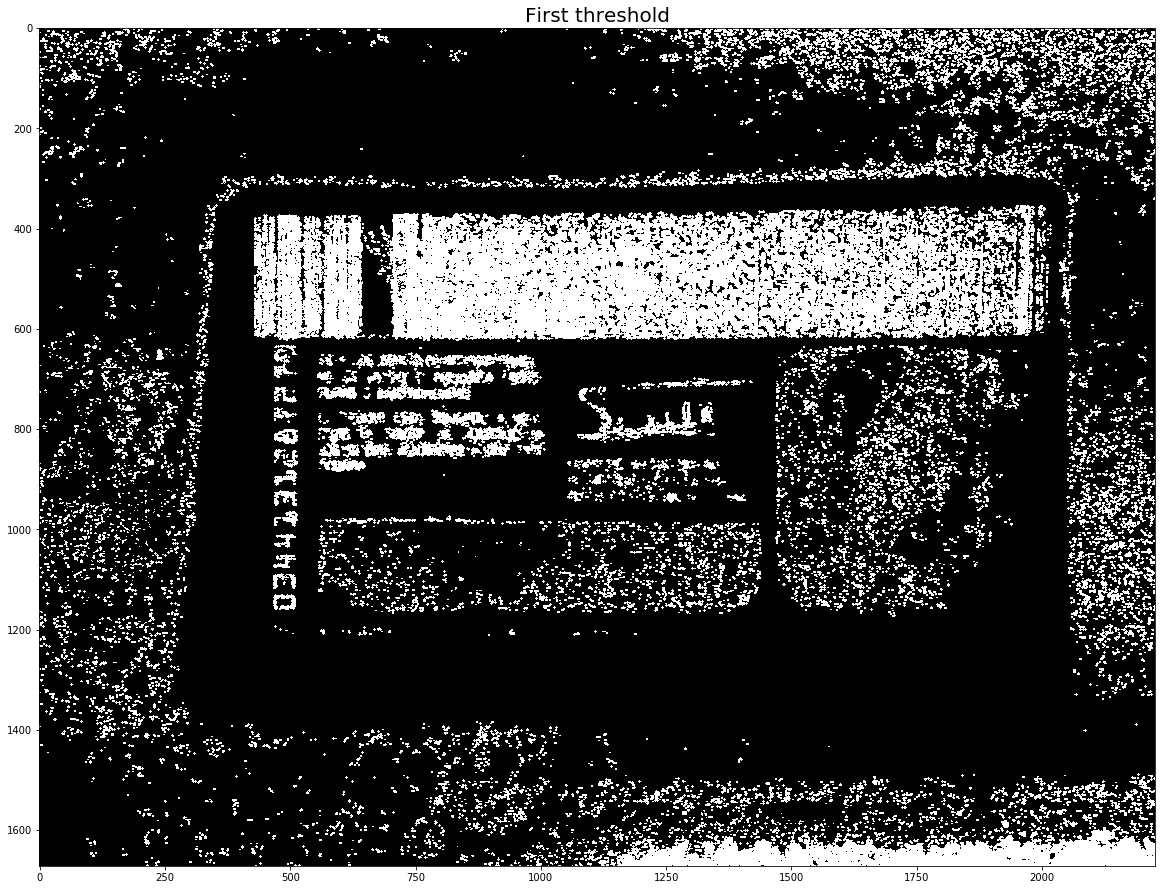

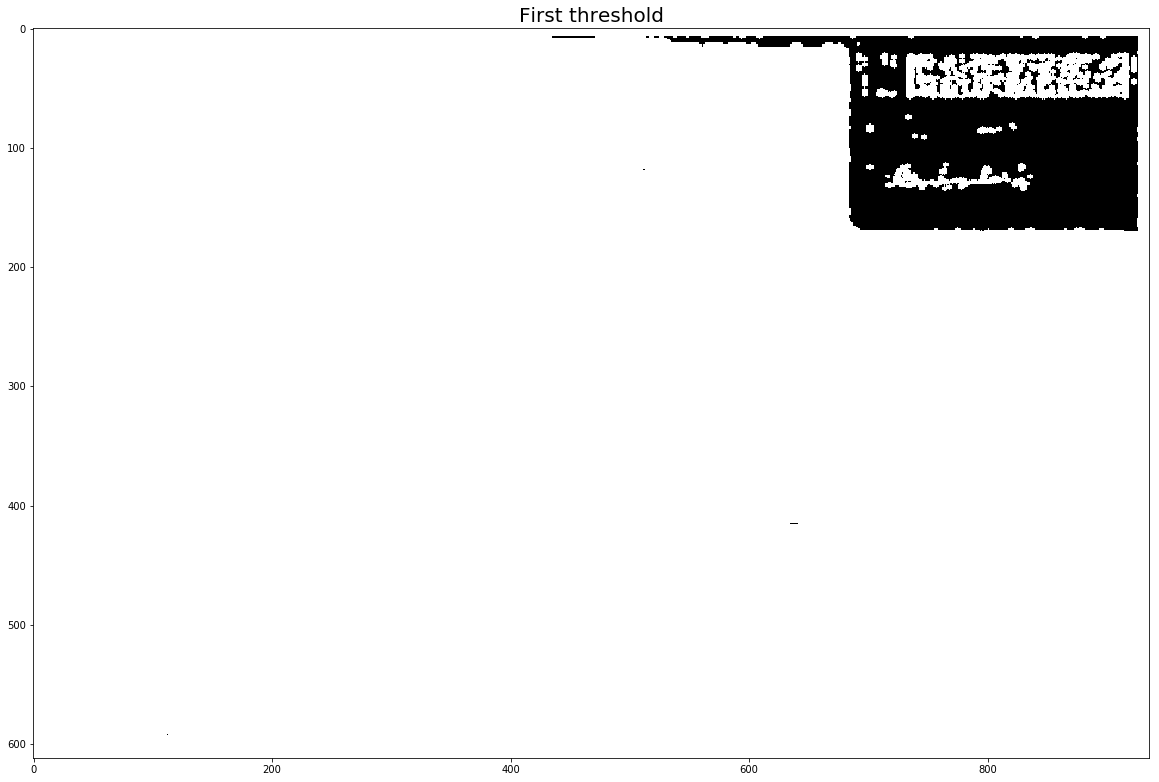

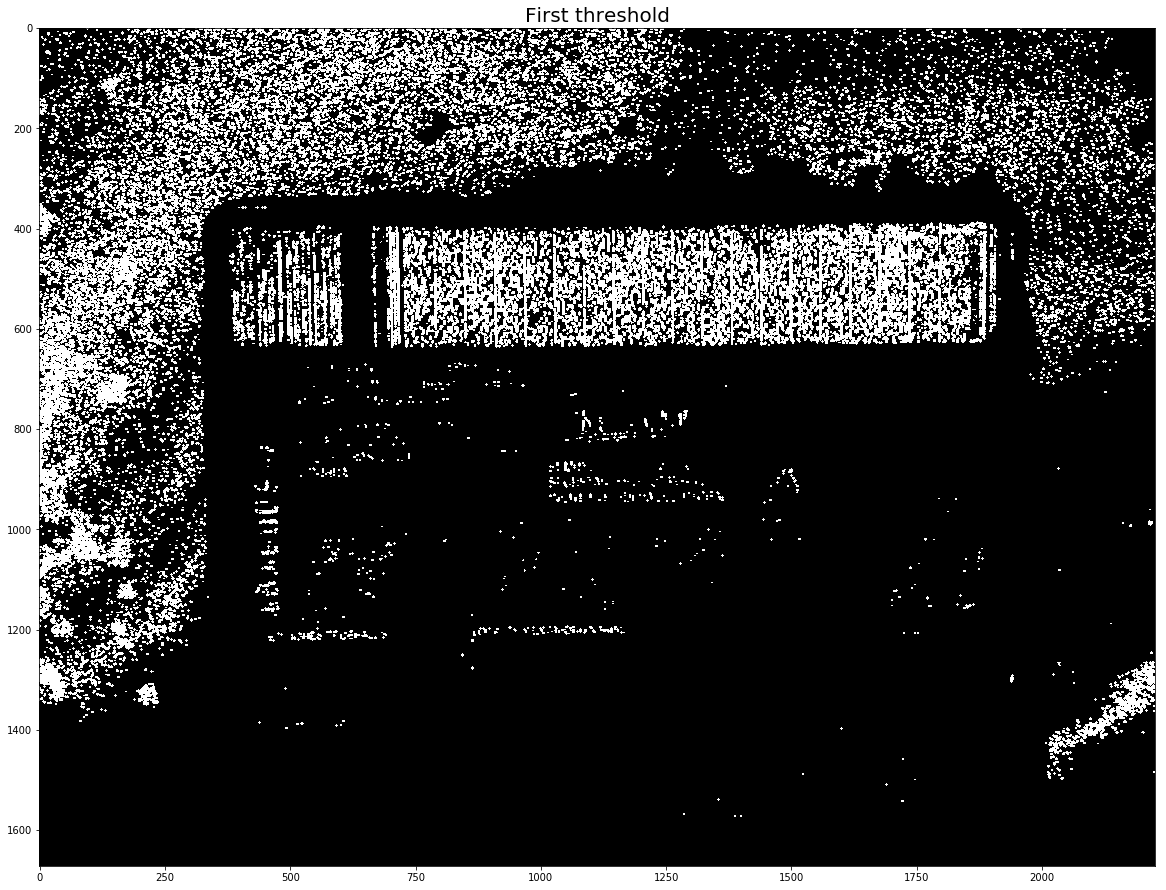

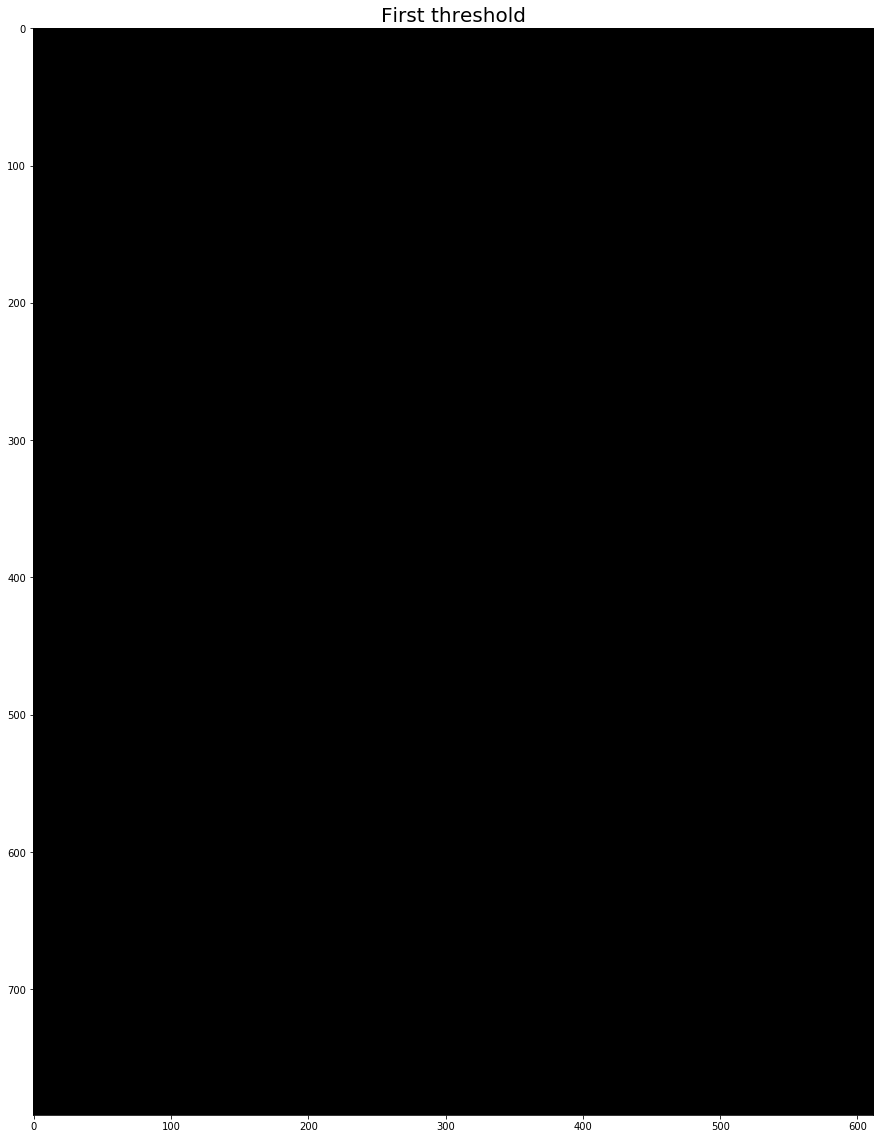

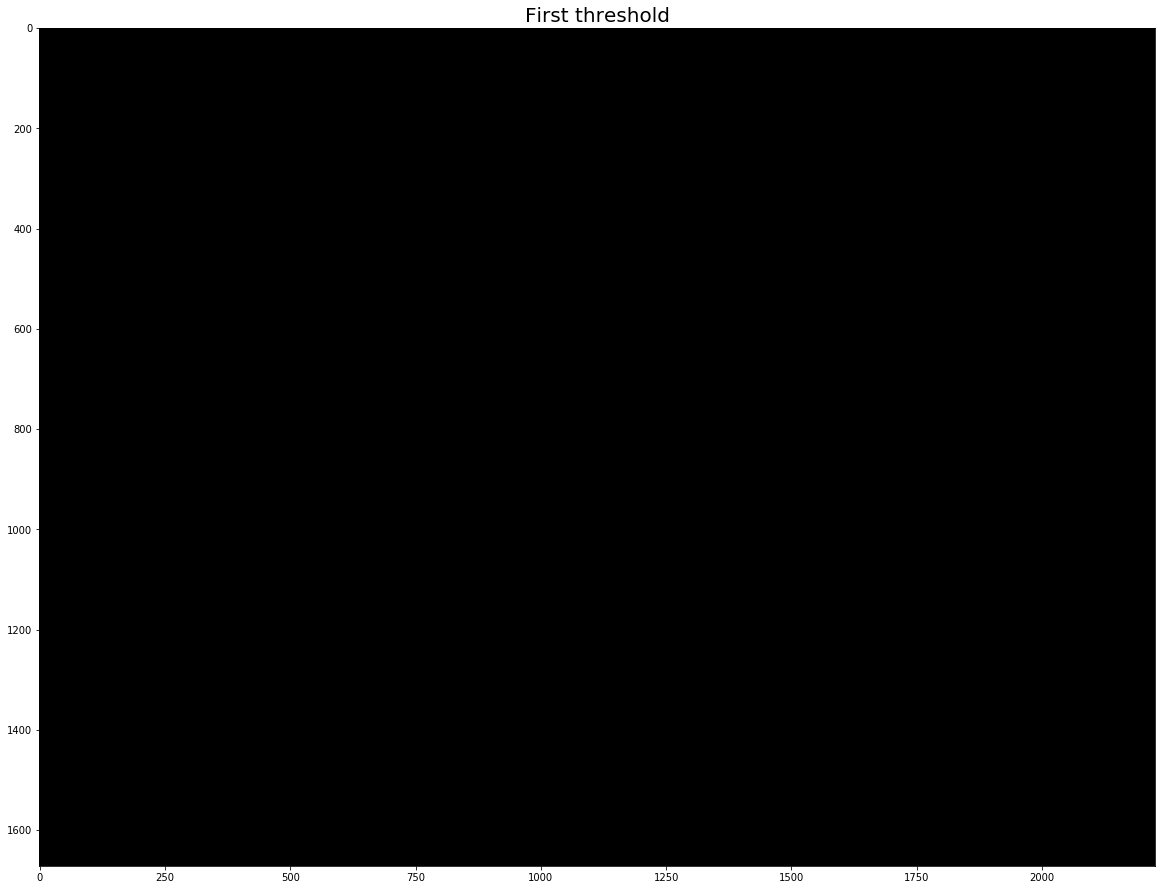

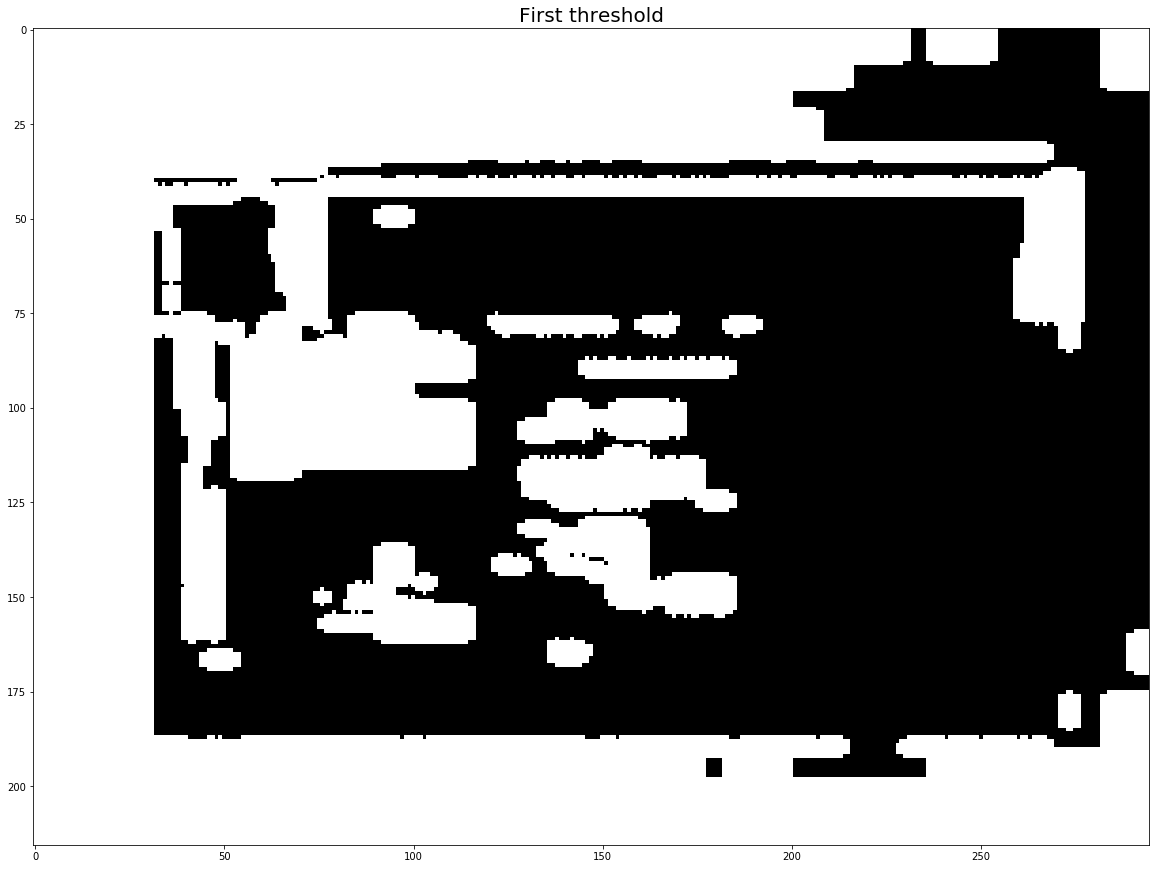

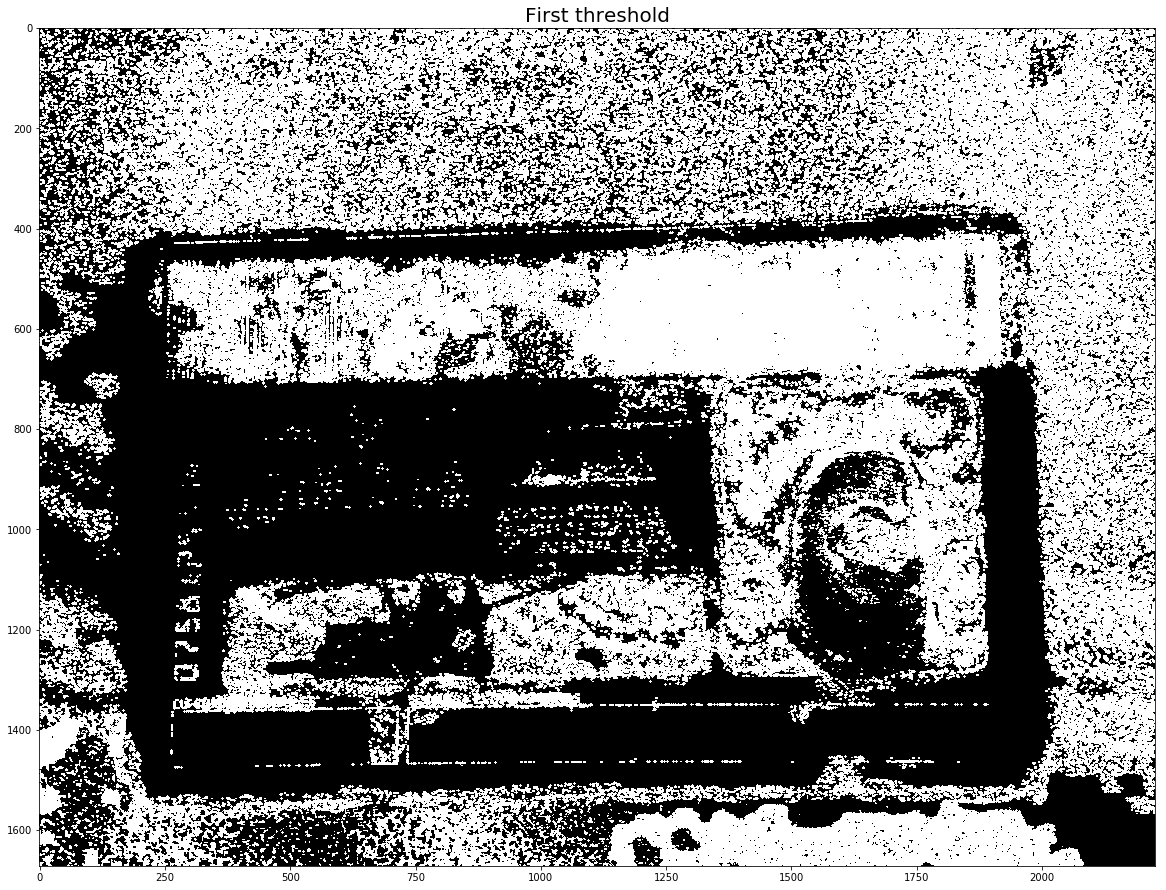

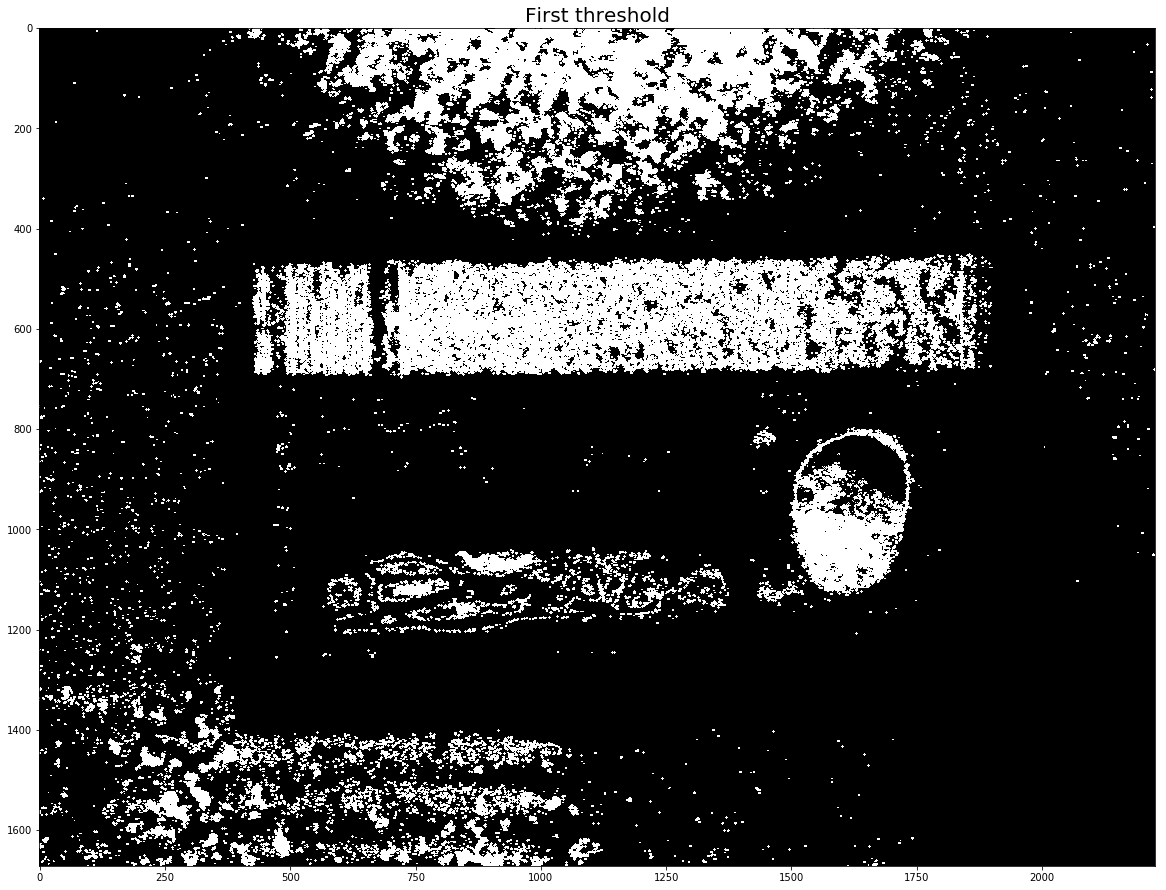

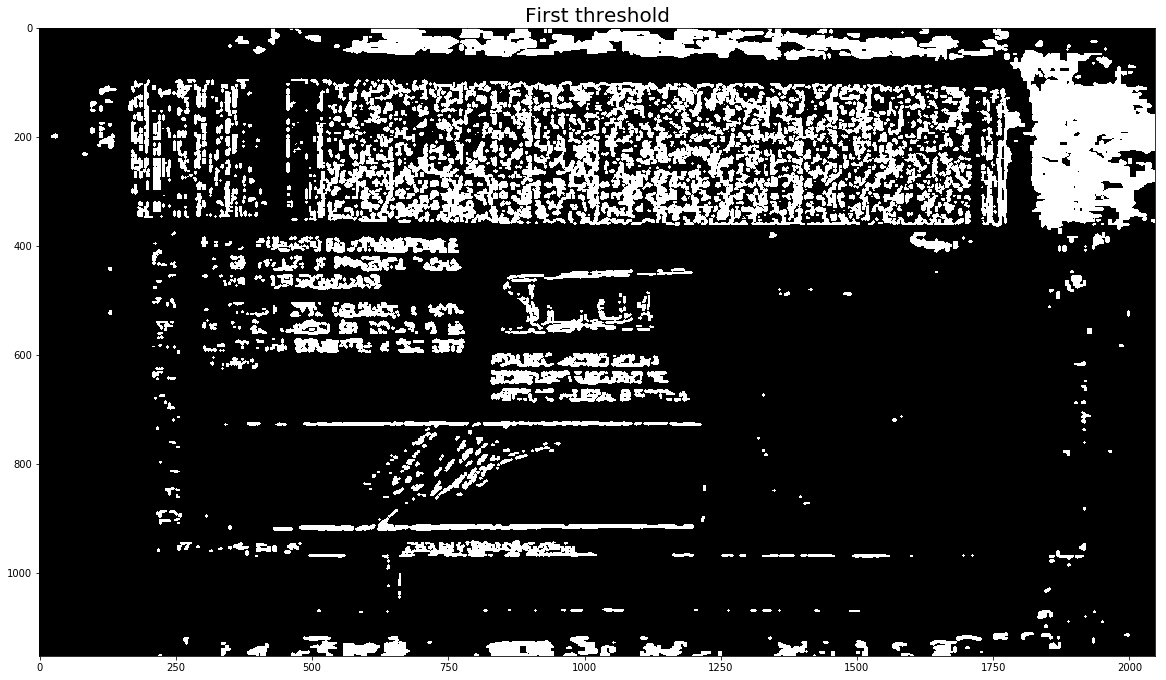

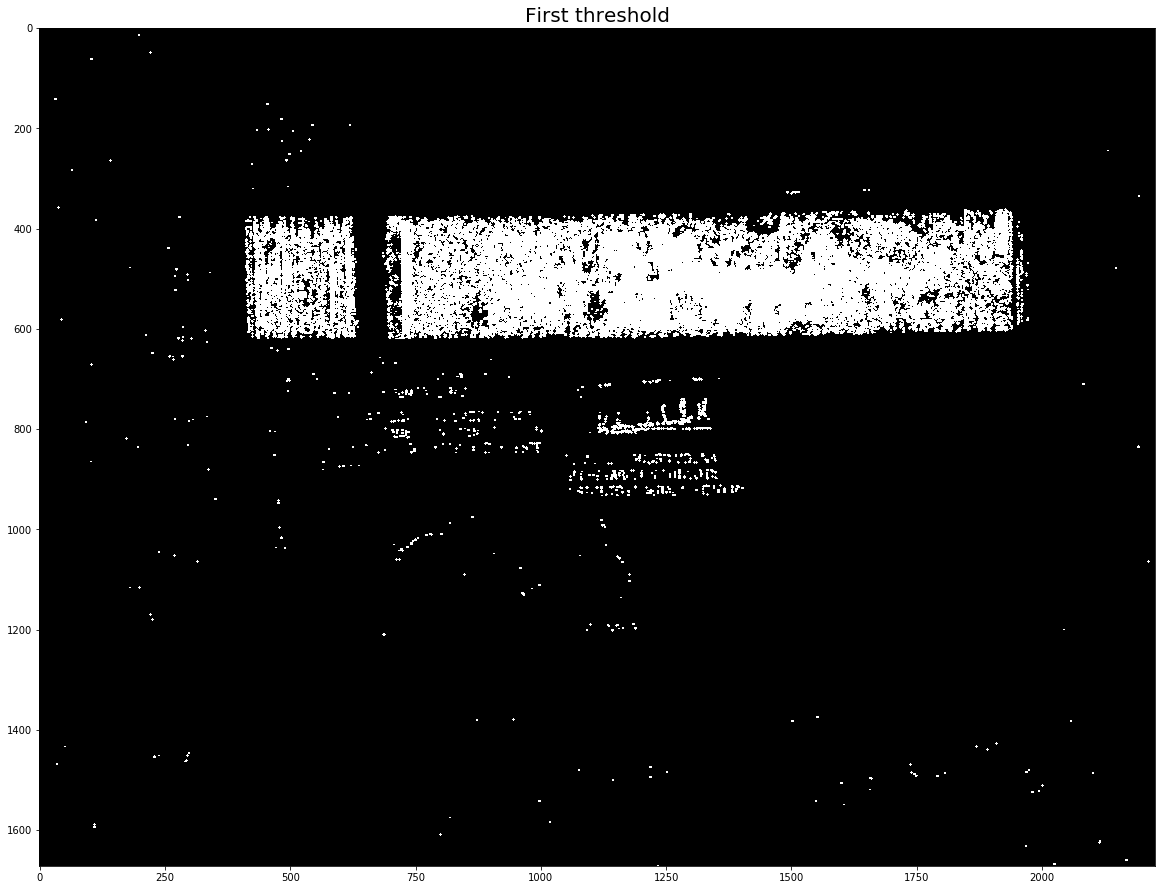

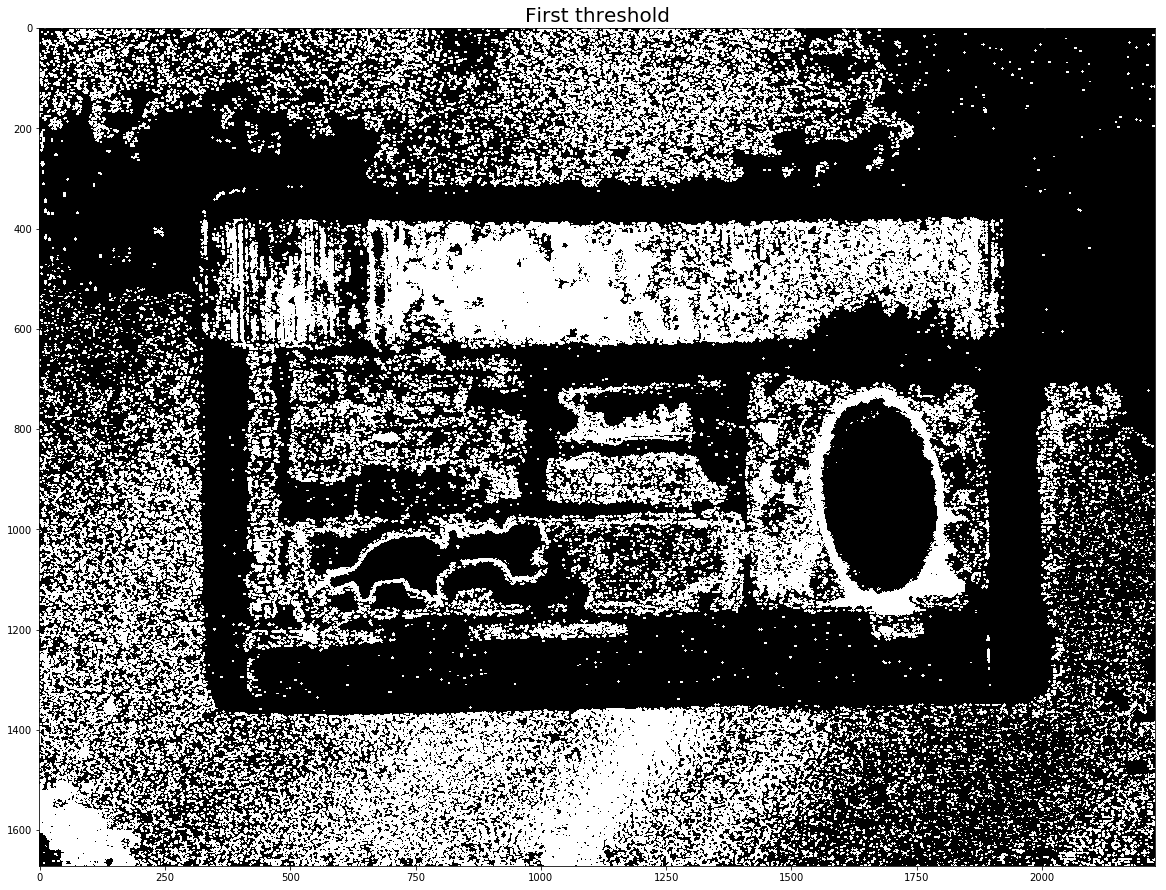

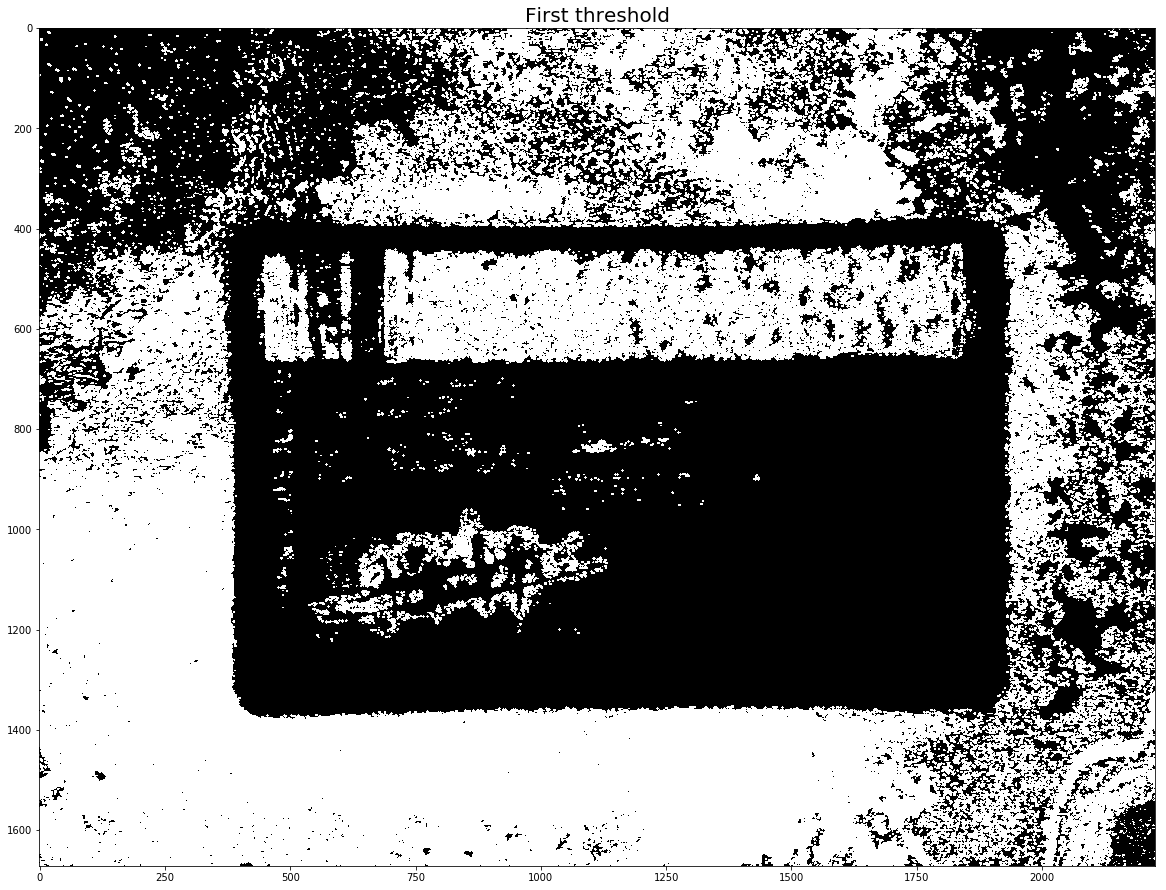

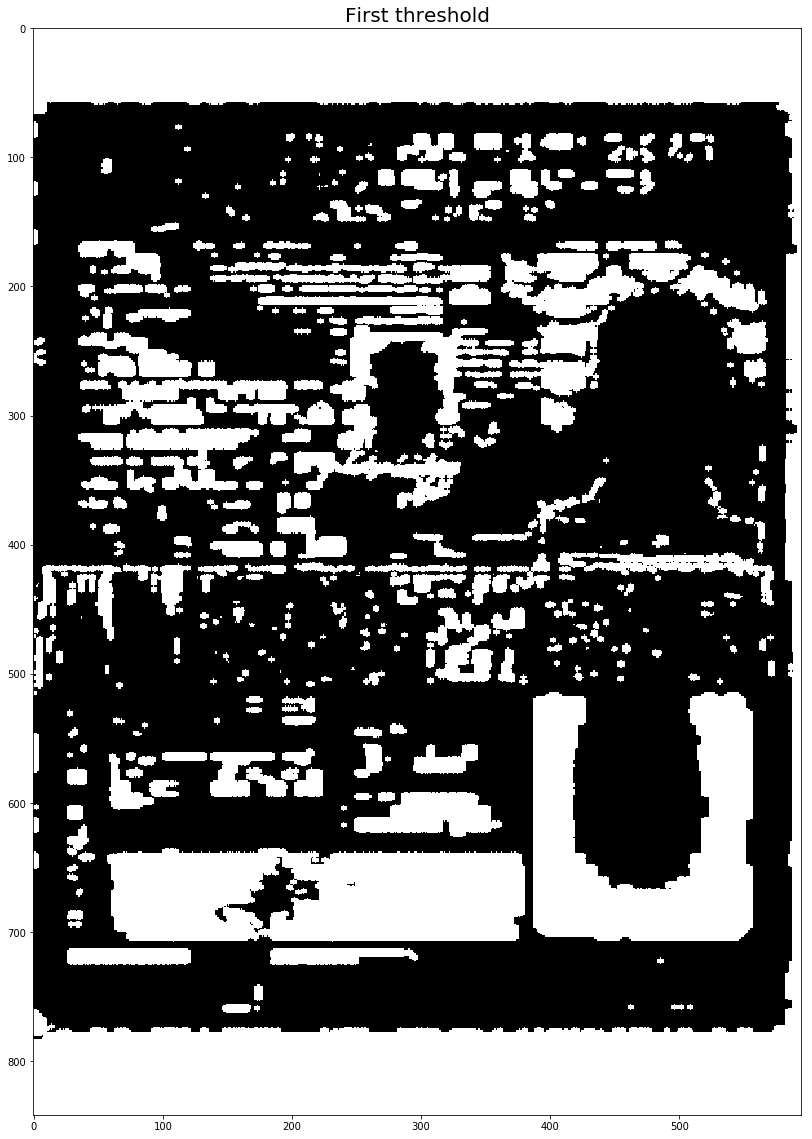

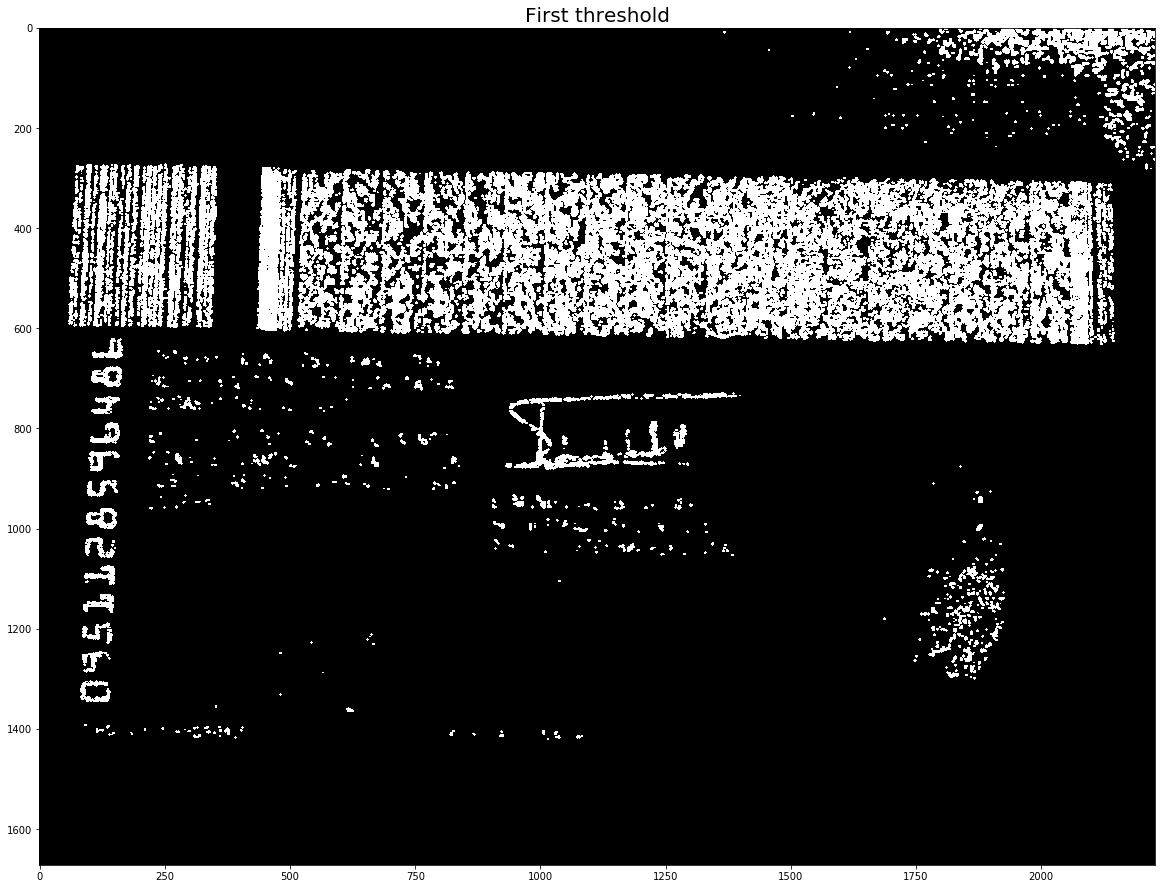

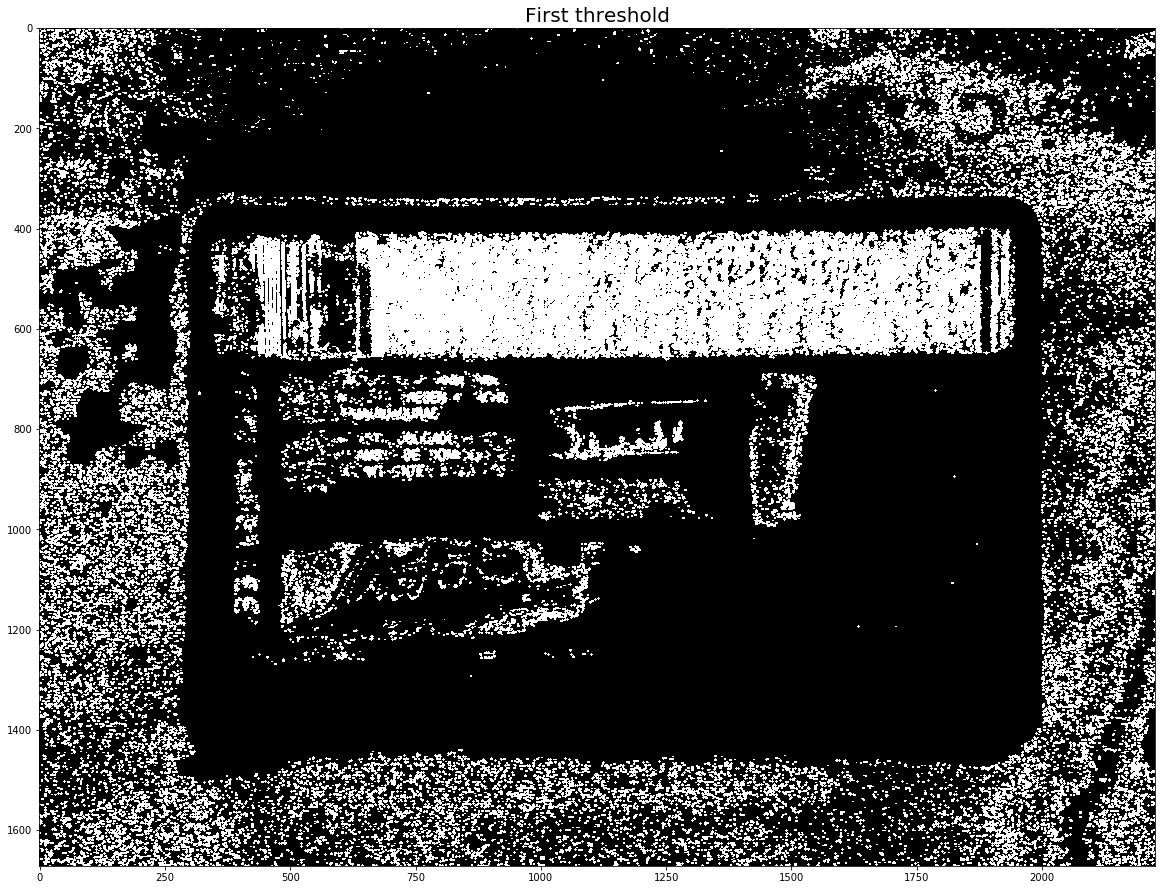

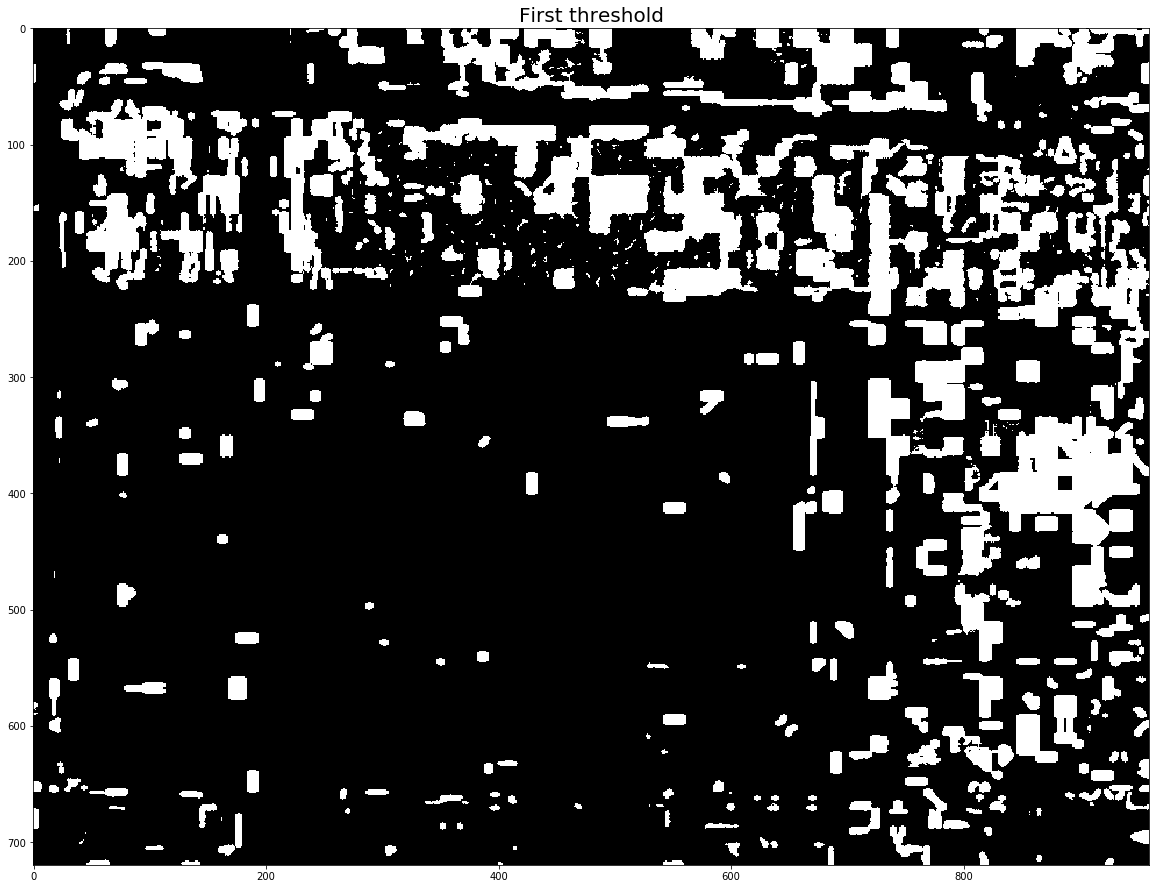

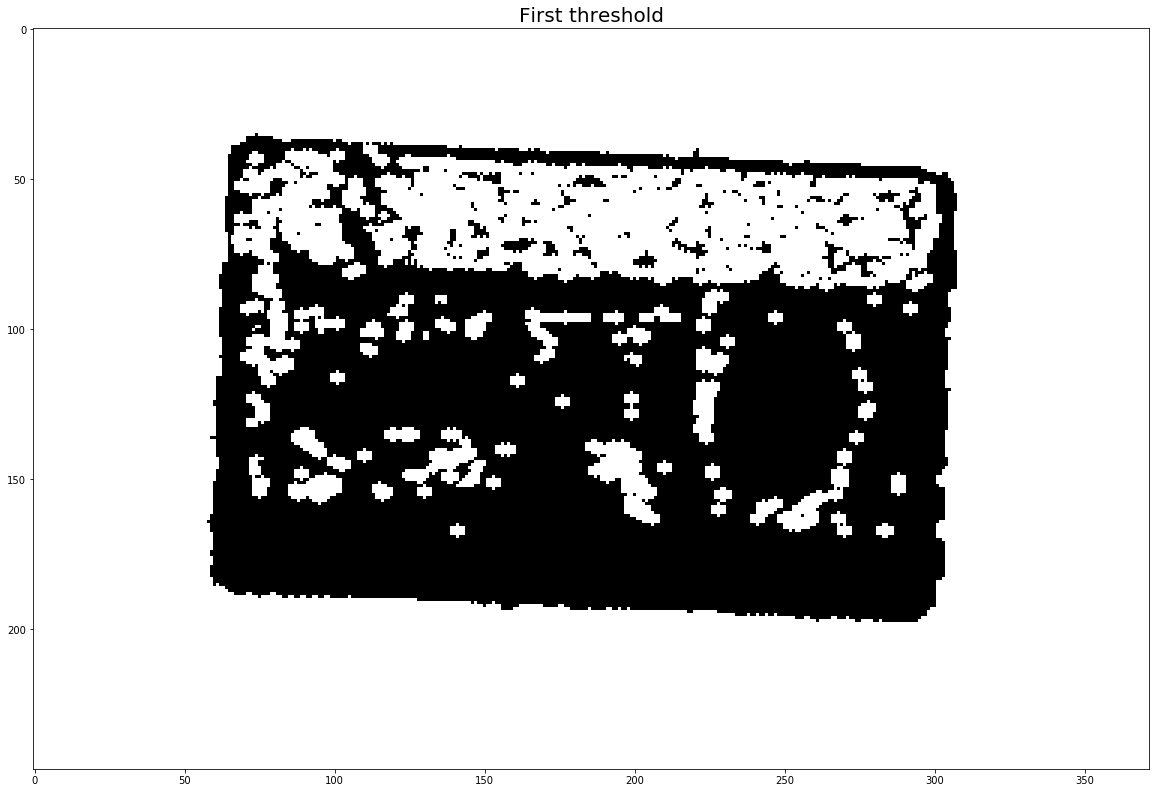

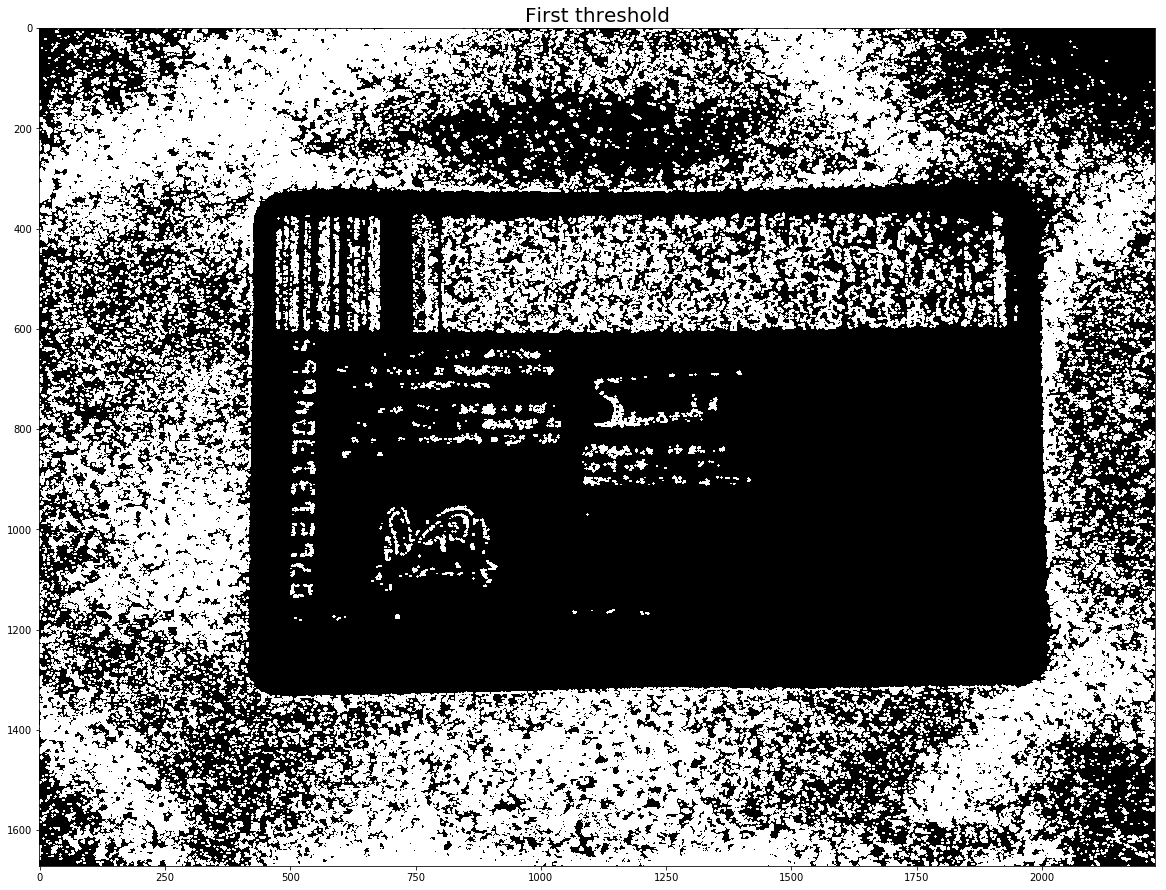

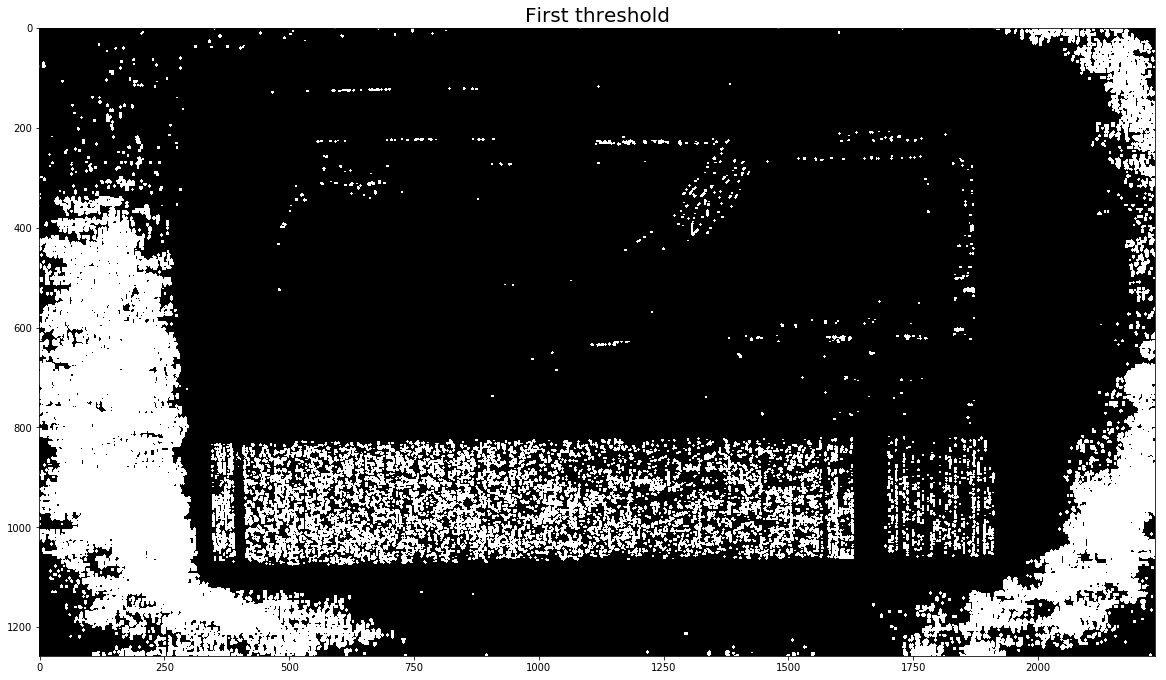

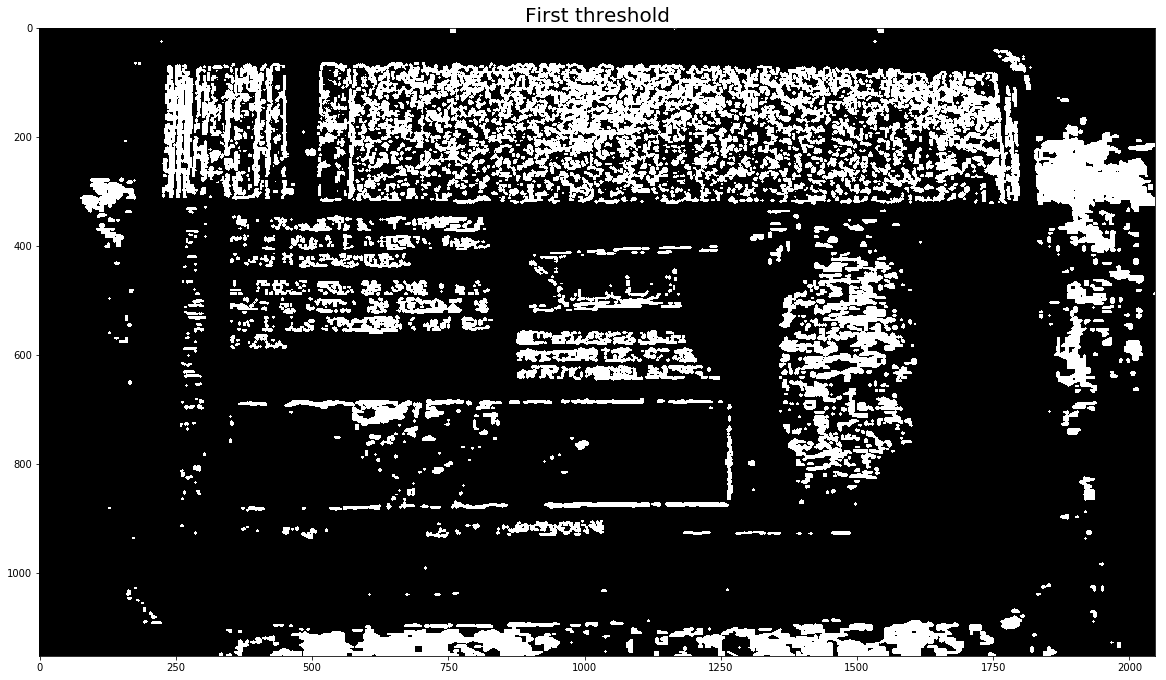

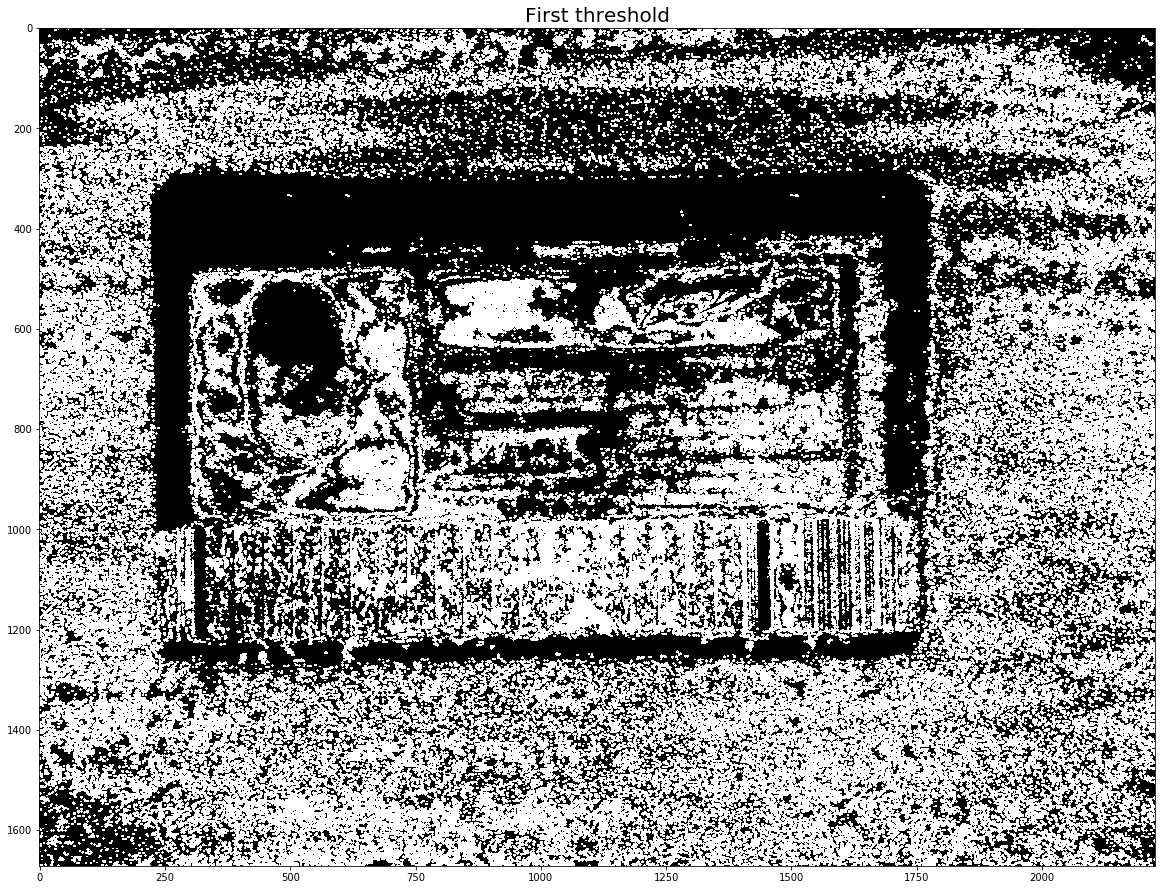

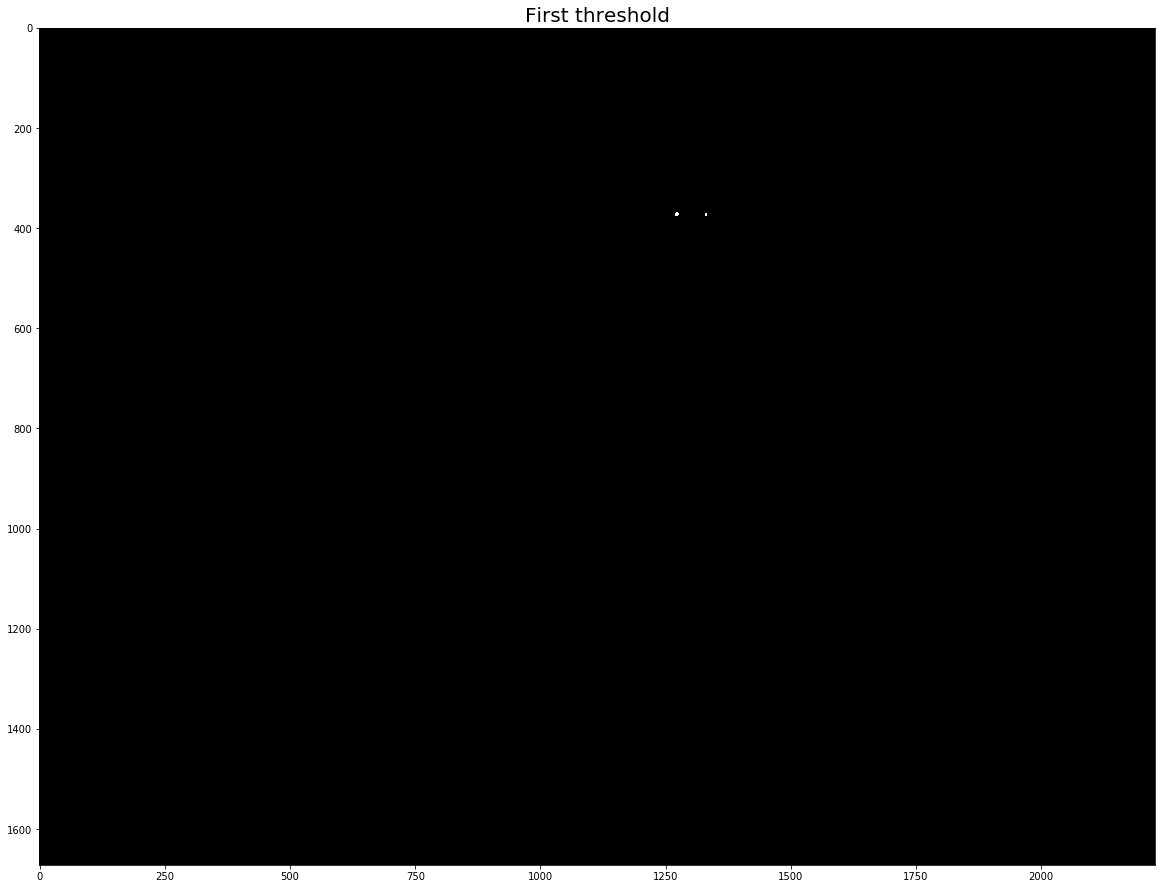

## Results

Good exctractions: 	0
Total documents: 	22
______________________________
Total Accuracy: 	0.0000


In [162]:
good = sum([True for image in images if main(image, False)])
display(Markdown('## Results'))
print(f"Good exctractions: \t{good}")
print(f"Total documents: \t{len(images)}")
print("______________________________")
print(f"Total Accuracy: \t{(good/len(images)):.4f}")